In [ ]:
#model with 32 and 16 dense layers and two dropout layer between them

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
from keras.utils import Sequence
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense


In [ ]:
train_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\train"
img_size=128
batch_size=64

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
class MergedGenerators(Sequence):
    def __init__(self, generators):
        self.generators = generators
        self.lengths = [len(gen) for gen in generators]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, index):
        generator_index = np.argmax(index < self.cumulative_lengths)
        if generator_index > 0:
            sample_index = index - self.cumulative_lengths[generator_index - 1]
        else:
            sample_index = index

        # Get the data and labels from the corresponding generator
        data, labels = self.generators[generator_index][sample_index]
        return data, labels

In [ ]:
def grayscale_conversion(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Repeat the single channel across three channels
    grayscale_image = np.stack((grayscale_image,) * 3, axis=-1)
    return grayscale_image

In [ ]:
normal_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
noisy_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),  # Add noise
)
shaded_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=[0.5, 1.5],  # Adjust the range for shading
)
grayscale_datagen = ImageDataGenerator(
    preprocessing_function= grayscale_conversion,
    rescale=1.0 / 255,
)

In [ ]:
generator1 = normal_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=41,
    class_mode='categorical'
)
generator2 = shaded_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)
generator3 = noisy_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=43,
    class_mode='categorical'
)
generator4 = grayscale_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=44,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.


In [ ]:
'''
# Get a batch of images from the generator
batch_images, batch_labels = generator4.next()

# Set the number of images to display in each row
num_images_per_row = 8

# Calculate the number of rows needed
num_rows = int(len(batch_images) / num_images_per_row) + 1

# Display the images
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(200, 200))

# Flatten the axes array if there is only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i in range(len(batch_images)):
    row_index = i // num_images_per_row
    col_index = i % num_images_per_row
    axes[row_index, col_index].imshow(batch_images[i])
    axes[row_index, col_index].axis('off')
plt.show()
'''


In [ ]:
combined_generator = MergedGenerators([generator1, generator2, generator3, generator4])

In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[img_size, img_size, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=32, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Dense(units=16, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

In [ ]:
test_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\val"
test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2400 images belonging to 5 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history=cnn.fit(x = combined_generator, validation_data = test_generator, epochs = 20, callbacks=[early_stopping])

Epoch 1/20
528/528 [==============================] - 154s 292ms/step - loss: 0.0888 - accuracy: 0.9234 - val_loss: 0.0481 - val_accuracy: 0.9700
Epoch 2/20
528/528 [==============================] - 139s 263ms/step - loss: 0.0689 - accuracy: 0.9373 - val_loss: 0.0370 - val_accuracy: 0.9700
Epoch 3/20
528/528 [==============================] - 157s 297ms/step - loss: 0.0626 - accuracy: 0.9397 - val_loss: 0.0232 - val_accuracy: 0.9842
Epoch 4/20
528/528 [==============================] - 176s 333ms/step - loss: 0.0543 - accuracy: 0.9489 - val_loss: 0.0260 - val_accuracy: 0.9821
Epoch 5/20
528/528 [==============================] - 154s 291ms/step - loss: 0.0508 - accuracy: 0.9526 - val_loss: 0.0229 - val_accuracy: 0.9833
Epoch 6/20
528/528 [==============================] - 131s 248ms/step - loss: 0.0477 - accuracy: 0.9561 - val_loss: 0.0293 - val_accuracy: 0.9850
Epoch 7/20
528/528 [==============================] - 130s 246ms/step - loss: 0.0482 - accuracy: 0.9561 - val_loss: 0.0321 -

In [ ]:
cnn.save(r'C:\Users\Acer\Desktop\Minor Project\Model_v7.h5')

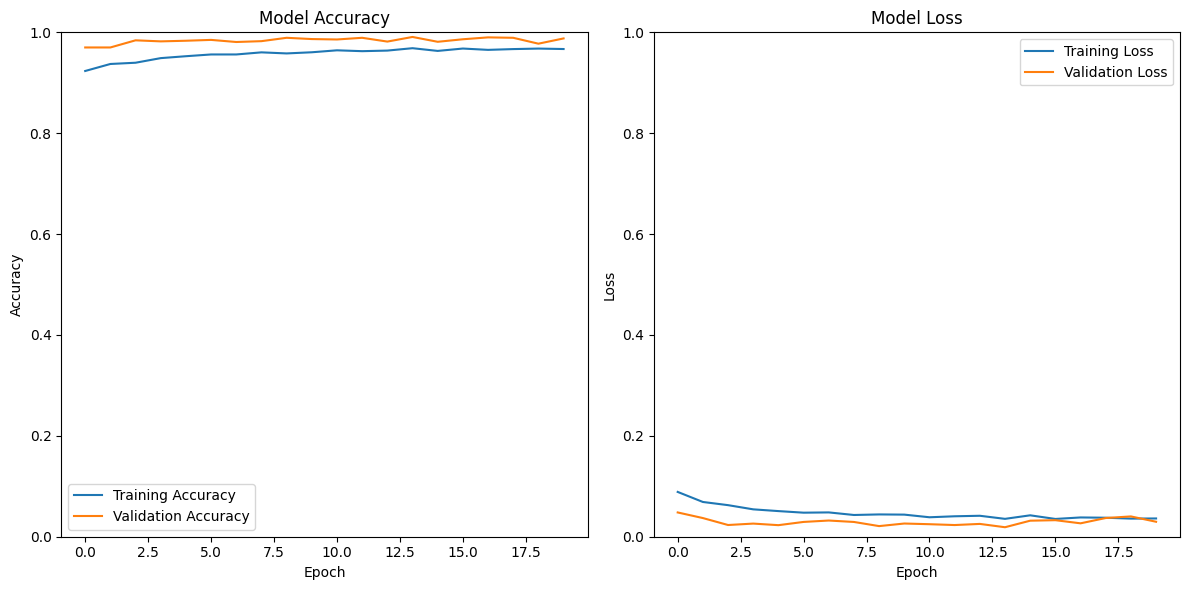

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()

Found 1200 images belonging to 5 classes.
19/19 [==============================] - 6s 297ms/step
F1 Score: 0.9875


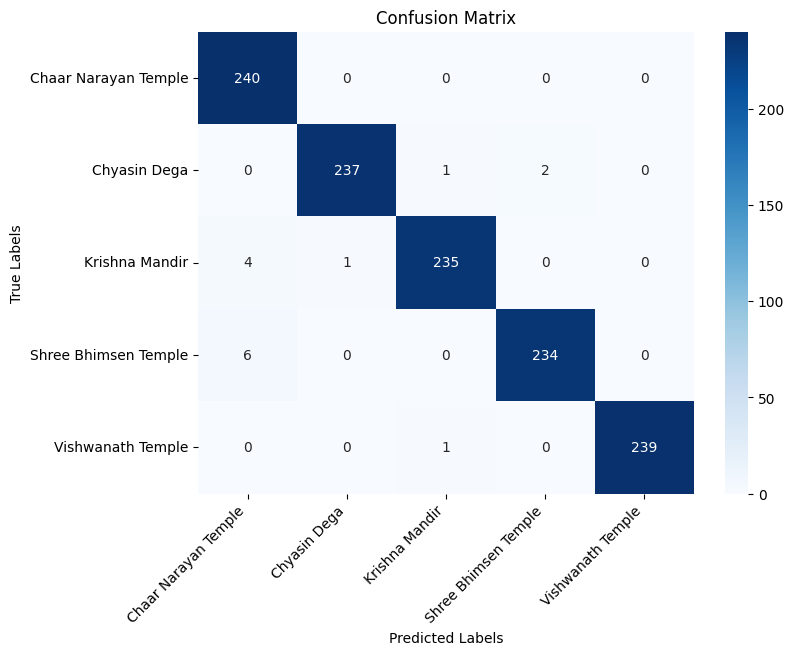

In [ ]:
import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
# Load the pre-trained model
model_path = r'C:\Users\Acer\Desktop\Minor Project\Model_v8.h5'
model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = r'C:\Users\Acer\Desktop\Minor Project\Split\test'

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()


In [18]:
import tensorflow as tf
import cv2
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model(r'C:\Users\Acer\Desktop\Minor Project\Model_v7.h5')

# Path to the single image you want to predict
img_path = r"C:\Users\Acer\Desktop\Screenshot 2024-01-20 112010.png"
class_names = ['Chaar Narayan Temple', 'Chyasin Dega', 'Krishna Mandir', 'Shree Bhimsen Temple', 'Vishwanath Temple']

import numpy as np
from PIL import Image

# Load the image using a suitable image library
img = Image.open(r"C:\Users\Acer\Desktop\vishwanath-mandir-temple.jpg").convert('RGB')

# Resize the image to match the model's input dimensions
img = img.resize((128, 128))  # Assuming model expects 128x128 images

# Convert the image to a NumPy array
img_array = np.array(img)

# Normalize pixel values to [0, 1] range (if model expects that)
img_array = img_array / 255.0

# Expand dimensions to create a batch of 1 image
img_batch = np.expand_dims(img_array, axis=0)

# Pass the image batch through the model
predictions = model.predict(img_batch)

# Extract the predicted probabilities for each class
probabilities = predictions[0]  # Access the probabilities for the first (and only) image
print(probabilities)

# ...

# Print class names along with predicted probabilities
for class_name, probability in zip(class_names, probabilities):
    probability_percentage = probability * 100
    print(f"{class_name}: {probability_percentage:.2f}%")
# ...




1/1 [==============================] - 0s 108ms/step
[3.1117579e-01 4.8261278e-04 1.1086150e-03 3.0903860e-03 6.8414271e-01]
Chaar Narayan Temple: 31.12%
Chyasin Dega: 0.05%
Krishna Mandir: 0.11%
Shree Bhimsen Temple: 0.31%
Vishwanath Temple: 68.41%
